# Mapping changing water extents through time

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/products/s2_l2a)



## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry

sys.path.append('../../Scripts')
from deafrica_datahandling import load_ard
from deafrica_bandindices import calculate_indices
from deafrica_plotting import xr_animation, display_map
from deafrica_dask import create_local_dask_cluster
from deafrica_spatialtools import xr_rasterize

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33983 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:
* `lat`: The central latitude to analyse (e.g. 10.338).
* `lon` : The central longitude to analyse (e.g. -1.055).
* `lat_buffer` : The number of degrees to load around the central latitude.
* `lon_buffer` : The number of degrees to load around the central longitude.
* `products`: The products to load from the datacube, e.g. `'s2_l2a``
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `min_gooddata`: This value sets the minimum amount of good data a scene must have before it will be loaded into memory e.g. `0.75` means only images with 75% good data will be retained.
* `measurements`: The spectral bands to load from the satellite product. MNDWI requires the green and swir1 bands, and cloud buffer requires the SCL band
* `resolution`: The pixel resolution of the satellite data.
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the Ruko Conservancy at 20m resolution.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [3]:
# Define the area of interest
lat = -19.
lon = 22.5

lat_buffer = 0.5
lon_buffer = 0.5

products = ['ls8_sr']

wetness_index = 'MNDWI'

time_range = ('2014-03', '2021-02')

min_gooddata = 0.10

measurements = ['green','swir_1']

resolution = (-30,30)

dask_chunks = {'time':1,'x':1250,'y':1250}


### Combine central lat,lon with buffer to get area of interest


In [4]:
lat_range = (lat - lat_buffer, lat + lat_buffer)
lon_range = (lon - lon_buffer, lon + lon_buffer)

In [5]:
display_map(lon_range, lat_range)

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [6]:
dc = datacube.Datacube(app='water_extent_shape')

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 

In [7]:
water_query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': measurements,
    'resolution': resolution,
    'output_crs': 'EPSG:6933',
    'dask_chunks': dask_chunks,
    'group_by':'solar_day'
              }

Now load the satellite data

In [8]:
ds = load_ard(dc=dc,
              products=products,
#               min_gooddata=min_gooddata,
              **water_query
                   )
print(ds)

Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls8_sr
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 315 time steps as a dask array
<xarray.Dataset>
Dimensions:      (time: 315, x: 3217, y: 4027)
Coordinates:
  * time         (time) datetime64[ns] 2014-03-01T08:25:40.809967 ... 2021-02...
  * y            (y) float64 -2.32e+06 -2.32e+06 ... -2.441e+06 -2.441e+06
  * x            (x) float64 2.123e+06 2.123e+06 ... 2.219e+06 2.219e+06
    spatial_ref  int32 6933
Data variables:
    green        (time, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
    swir_1       (time, y, x) float32 dask.array<chunksize=(1, 1250, 1250), meta=np.ndarray>
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


## Cloud Buffering

The cloud masking data for Sentinel-2 is less than perfect. Below we will buffer the cloud-masking bands in an attempt to improve the masking of poor quality data.

In [10]:
# import odc.algo

# #Extract boolean mask
# mask = odc.algo.enum_to_bool(ds.SCL, 
#                              categories=['cloud shadows', 'cloud medium probability',
#                                          'cloud high probability', 'thin cirrus'])
                             
# # Close mask to remove small holes in cloud, open mask to 
# # remove narrow false positive cloud, then dilate
# mask = odc.algo.binary_closing(mask, 2)
# mask_cleaned = odc.algo.mask_cleanup(mask, r=(2, 10))

# # Add new mask as nodata pixels
# ds = odc.algo.erase_bad(ds, mask_cleaned)

# #remove SCL since we don't need it anymore
# ds = ds.drop('SCL')

## Calculate the wetness index

In [11]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds=ds, index=[wetness_index], collection='s2')

# drop green and swir since we don't need it
ds = ds.drop(['green','swir_1'])

## Resample time series

Due to many factors (e.g. cloud obscuring the region, missed cloud cover in the SCL layer) the data will be gappy and noisy. Here, we will resample the data to ensure we working with a consistent time-series.

To do this we resample the data to seasonal time-steps using medians

These calculations will take several minutes to complete as we will run `.compute()`, triggering all the tasks we scheduled above and bringing the arrays into memory.

In [12]:
%%time
sample_frequency="QS-DEC"  # quatrley starting in DEC, i.e. seasonal

#resample MNDWI using medians
print('calculating '+wetness_index+' seasonal medians')
ds = ds.resample(time=sample_frequency).median().compute()


calculating MNDWI seasonal medians
CPU times: user 52 s, sys: 4.85 s, total: 56.8 s
Wall time: 4min 52s


### Facet plot the wetness index time-steps

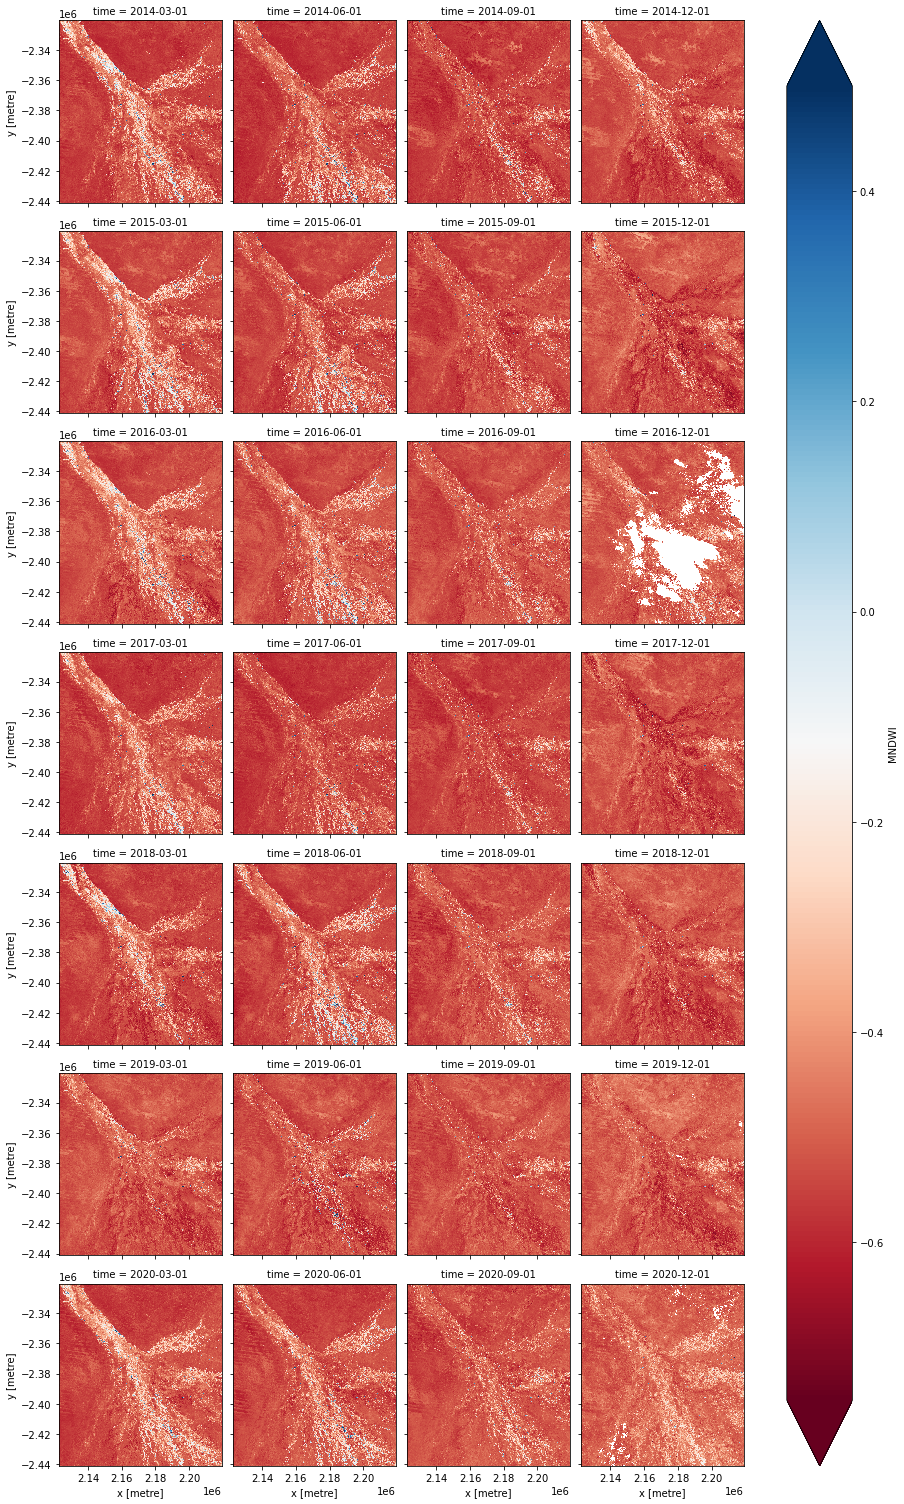

In [13]:
ds[wetness_index].plot.imshow(col='time', col_wrap=4, cmap='RdBu', vmax=0.5, vmin=-0.75);

## Calculate the water extent per time-step

The number of pixels can be used for the area of the waterbody if the pixel area is known. 
Run the following cell to generate the necessary constants for performing this conversion.

In [14]:
pixel_length = water_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

## Calculating the extent of open water
Calculates the area of pixels classified as water (if MNDWI is > 0, the water)

In [15]:
water = ds[wetness_index].where(ds[wetness_index] > 0, np.nan)

area_ds = water.where(np.isnan(water),1)

ds_valid_water_area = area_ds.sum(dim=['x', 'y']) * area_per_pixel

### Plot time series of water area

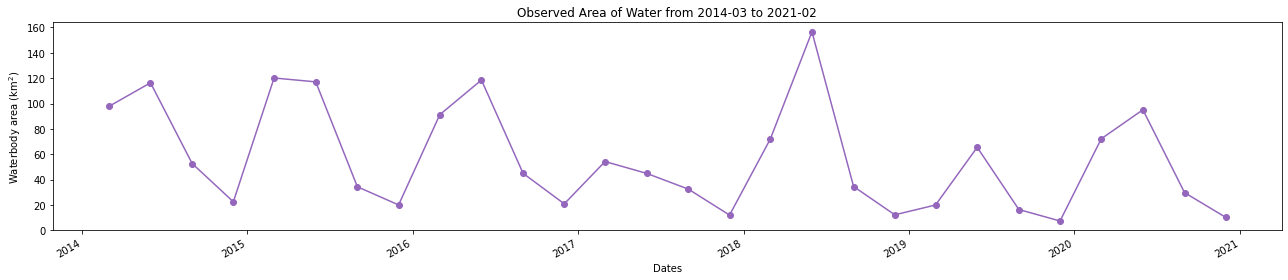

In [16]:
plt.figure(figsize=(18, 4))
ds_valid_water_area.plot(marker='o', color='#9467bd')
plt.title(f'Observed Area of Water from {time_range[0]} to {time_range[1]}')
plt.xlabel('Dates')
plt.ylabel('Waterbody area (km$^2$)')
plt.tight_layout()

## Compare water extent between two periods

* `baseline_time` : The baseline year for the analysis
* `analysis_time` : The year to compare to the baseline year

* The water extent for the two time-periods are extracted from the datatset `ds_valid_water_area`

In [17]:
baseline_time = '2018-06-01'
analysis_time = '2019-06-01'

baseline_ds, analysis_ds = ds_valid_water_area.sel(time=baseline_time, method ='nearest'),ds_valid_water_area.sel(time=analysis_time, method ='nearest')

In [18]:
time_xr = xr.DataArray([baseline_ds.time.values, analysis_ds.time.values], dims=["time"])
print(time_xr)

<xarray.DataArray (time: 2)>
array(['2018-06-01T00:00:00.000000000', '2019-06-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Dimensions without coordinates: time


## Plotting
Plot water extent of the MNDWI product for the two chosen periods.

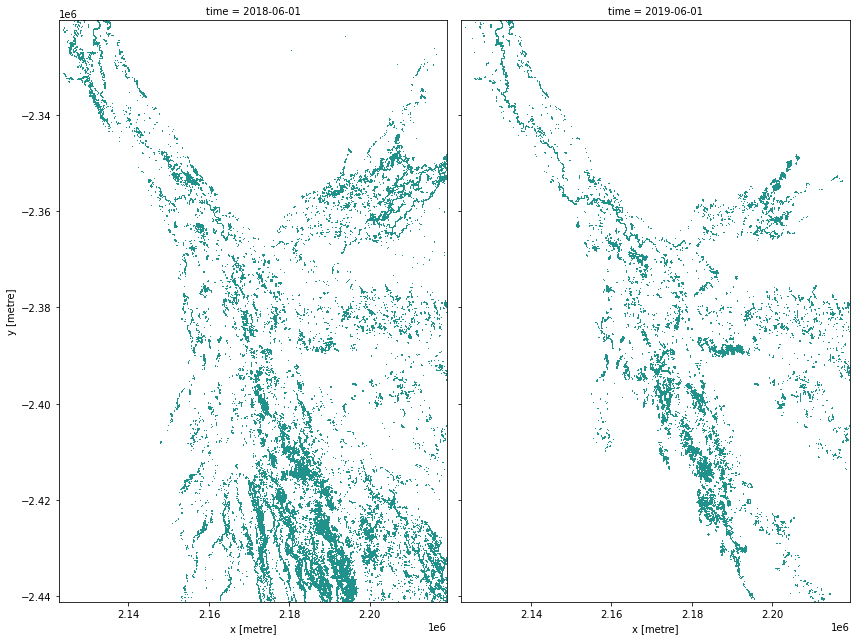

In [19]:
area_ds.sel(time=time_xr).plot(col="time", col_wrap=2, robust=True, figsize=(12, 9), cmap='viridis', add_colorbar=False);

### Calculate the change between the two nominated periods

The cells below calculate the amount of water gain, loss and stable for the two periods

In [20]:
# The two period Extract the two periods(Baseline and analysis) dataset from
ds_selected = area_ds.where(area_ds == 1, 0).sel(time=time_xr)

#The dataset array is transform to 1 and 0 using the `astype(int)` function.
analyse_total_value = ds_selected[1]
change = analyse_total_value - ds_selected[0]

#The various scenarios are extracted from the `change` variable for the two years
#Water gain  is 1
water_appeared = change.where(change == 1)

#Permanent water = 0
permanent_water = change.where((change == 0) & (analyse_total_value == 1))

#Permanent Land = 0
permanent_land = change.where((change == 0) & (analyse_total_value == 0))

#Water loss = -1
water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [21]:
total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
permanent_land_area = permanent_land.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

The cell below calculate the percentage of area of water extent for water_loss, water_gain, permanent water and land 

In [22]:
# Percentage Change in water extent
percentage_water_gain = round(water_apperaed_area, 2)
percentage_water_loss = round(water_disappeared_area, 2)
percentage_permanent_water = round(permanent_water_area, 2)
percentage_permanent_land = round(permanent_land_area, 2)

## Plot the changes
The water variables are plotted to visualised the result

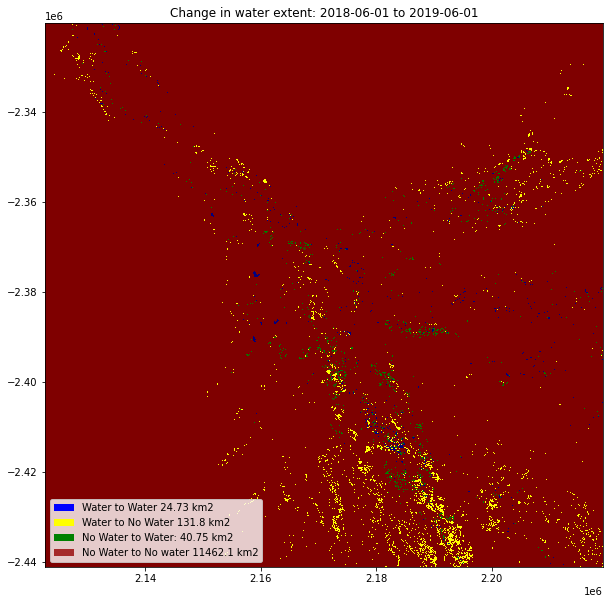

In [23]:
water_appeared_color = 'Green'
water_disappeared_color = 'Yellow'
stable_color = 'Blue'
land_color = 'Brown'

plot_aspect = image_aspect(area_ds)

ds_selected[1].plot.imshow(cmap='jet_r', add_colorbar=False, add_labels=False, figsize=(10,10))
water_appeared.plot.imshow(cmap=ListedColormap([water_appeared_color]), add_colorbar=False, add_labels=False)
water_disappeared.plot.imshow(cmap=ListedColormap([water_disappeared_color]), add_colorbar=False, add_labels=False)

plt.legend(
        [Patch(facecolor=stable_color), Patch(facecolor=water_disappeared_color), Patch(facecolor=water_appeared_color),   Patch(facecolor=land_color)], 
        [f'Water to Water {percentage_permanent_water} km2', f'Water to No Water {percentage_water_loss} km2' , f'No Water to Water: {percentage_water_gain} km2',  
         f'No Water to No water {percentage_permanent_land} km2'],
         loc = 'lower left'
    );

plt.title('Change in water extent: '+baseline_time+' to '+analysis_time);

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')